# Importing pandas and numpy

In [1]:
import numpy as np
import pandas as pd
from time import time

# Loading Dataset

In [2]:
df = pd.read_csv('github_comments.tsv', encoding="utf-8", delimiter='\t',index_col=0,
                 parse_dates = ['comment_date','merged_at'],
                 dtype={'comment':str,'is_merged': bool,'request_changes':bool}
                 )
df.head()

,comment,comment_date,is_merged,merged_at,request_changes
0,@chef/maintainers,2017-05-29 10:54:23,False,NaT,False
1,omnibus builds are already in pain so merging ...,2017-05-25 20:34:45,True,2017-05-25 20:34:27,False
2,@chef/client-core reviewage (lets not think to...,2017-05-25 17:21:56,True,2017-05-25 19:05:10,False
3,This blows up 14.04 because allow-downgrades i...,2017-05-25 19:15:14,False,NaT,True
4,I know @lamont-granquist and @thommay are goi...,2017-05-23 22:58:13,True,2017-05-24 04:40:42,False


# Get information about the dataset (types, nb columns, nb rows, etc. )

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4001 entries, 0 to 4000
Data columns (total 5 columns):
comment            4001 non-null object
comment_date       4001 non-null datetime64[ns]
is_merged          4001 non-null bool
merged_at          1159 non-null datetime64[ns]
request_changes    4001 non-null bool
dtypes: bool(2), datetime64[ns](2), object(1)
memory usage: 132.8+ KB


# Check for NaNs
Only the column merged_at has Nans: it represents the date at which the pull request was merged (if accepted).


In [4]:
df.isnull().sum()

comment               0
comment_date          0
is_merged             0
merged_at          2842
request_changes       0
dtype: int64

# Reading some comments

In [5]:
pd.set_option('display.max_colwidth', -1)
df.comment.sample(n=10,random_state=404)

1418    Doh, I am sorry, I'd been using that to deploy releases to my local nexus so we could use it in my projects! I didn't mean to include this file in the commit. I'll try to undo it.\n                                                                                                                                                                                                                     
2391    Same as above, I think this should something like that:\r\n\r\n```\r\ncatch (Throwable t1) {\r\n\ttry {\r\n\t\tif ( transaction.isActive() ) {\r\n\t\t\ttransaction.rollback();\r\n\t\t}\r\n\t}\r\n\tcatch(Throwable t2) {\r\n\t\tsomeLogger.warn("Error while automatically rolling back a transaction", e); // Maybe we could remove that\r\n\t\tt1.addSuppressed(t2);\r\n\t}\r\n\tthrow t1;\r\n}\r\n```
842     @rwinch fixed\n                                                                                                                                                                           

# The most common problems that appear in these comments:

### The comments (texts) contain:

- codes (for instance: JAVA)

- urban language  (for instance: Doh)

- links (for instance: https://hibernate.atlassian.net/browse/HBX-1225)

- emojis (for instance: ':)')

- combinaisation between english and code (for instance:How is it different from `ConstraintLocation#getTypeForValidatorResolution()`? )

- tags and references (for instance: '@ge0ffrey')

- spaces and tabs (for instance: '\n \t')

- unstructured text: no fixed layout, no frequent pattern, different length, etc.


### Furthermore, we can detect 4 behaviors in these observations:
-  request_changes and is_merged are true:  an accepeted and merged request that contains modification 
-  request_changes is true and is_merged is false:  these are probably not solved issues.
-  request_changes and is_merged are false:  I can't find an interesting assumption in this behavior maybe it is just a comment or an opinion that doesnt require changes in code.
-  request_changes is false and is_merged is true: probably merged Pull requests without any issue  


In [6]:
#group comments by is_merged & request_changes
df.groupby(['is_merged','request_changes']).size()


is_merged  request_changes
False      False              1906
           True               936 
True       False              875 
           True               284 
dtype: int64

# Text Cleaning

### tokenization
The function below is used to clean and tokenize our text.

In [8]:
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()

def tokenize(text):
    out_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            out_tokens.append('URL')
        elif token.like_email:
            out_tokens.append('EMAIL')
        elif token.orth_.startswith('@'):
            out_tokens.append('USER_NAME')
        elif token.orth_.startswith('#'):
            out_tokens.append('REF_')
        else:
            out_tokens.append(token.lower_)
    return out_tokens

 ###  Text normalization
 we used WordNetLemmatizer to get the root of every word.

In [9]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')

def get_lemma(word):
    return WordNetLemmatizer().lemmatize(word)

[nltk_data] Downloading package wordnet to /home/malek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### remove the stop words from the text

In [10]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/malek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Furthermore we will keep only words (NOUNS,ADJ,ADV,VB) with lenth greater than 3 chars and that contains only alphabet

In [11]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 3]
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    text = ' '.join(tokens)
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    tokens = [word for word,pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS' or pos == 'JJ' or pos == 'VB' or pos == 'RB')]
    return tokens

### we apply the cleaning steps on every comment

In [12]:
data = [prepare_text_for_lda(comment) for comment in df.comment.values ]

In [13]:
print(data[:5])

[['maintainer'], ['omnibus', 'build', 'already', 'pain', 'merging'], ['client', 'core', 'reviewage', 'think', 'hard', 'breakpoint', 'resource', 'provider', 'code'], ['blow', 'allow', 'downgrade', 'need', 'figure', 'first', 'version', 'ubuntu', 'debian', 'safely', 'support', 'conditionally', 'flag'], ['know', 'granquist', 'unhappy', 'absolutely', 'short', 'term', 'choco', 'window', 'jenkins', 'system', 'failure']]


### Adding bigrams
We find bigrams in the documents. Bigrams are sets of two adjacent words. Using bigrams we can get phrases like "machine_learning" in our output (spaces are replaced with underscores); without bigrams we would only get "machine" and "learning".  The code below, we find bigrams and then add them to the original data, because we would like to keep the words "machine" and "learning" as well as the bigram "machine_learning".

In [14]:
from gensim.models import Phrases

# Add bigrams and trigrams to docs (if they appear more than 10 times).
bigram = Phrases(data, min_count=10)
for idx in range(len(data)):
    for token in bigram[data[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            data[idx].append(token)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Then we will create a cbow dictionnary and save it. We remove rare words and common words based on their document frequency. Below we remove words that appear in less than 20 documents or in more than 50% of the documents.

In [15]:
import gensim
import pickle

from gensim import corpora
dictionary = corpora.Dictionary(data)
dictionary.filter_extremes(no_below=20, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in data]

pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

# Building LDA model: for Topic modeling 
we will use Gensim to build and train the model


### The following function apply a gridsearch to get the best LDA model using our corpus, the used metric is c_v coherence

to find the optimal number of topics.We need to build many LDA models with different values of the number of topics (k) and pick the one that gives the highest coherence value.

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus,random_state=404, 
                                              per_word_topics =True,  passes=15 ,id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = gensim.models.coherencemodel.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

### Next we will display the results obtained: 

we see that 5 is the best number of topics to choose with a score 0.4206. Also 8 and 11 have a close scores.

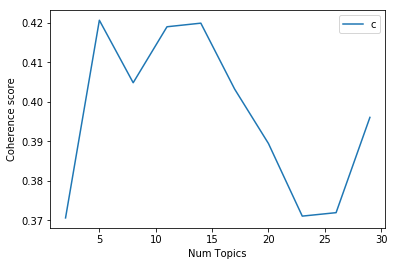

In [17]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=data, start=2, limit=30, step=3)
# Show graph
import matplotlib.pyplot as plt
%matplotlib inline 
limit=30; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [18]:
print(coherence_values)
print('the best coherence_values is:', max(coherence_values))

[0.3706380075958, 0.4206379226836261, 0.4048317097543631, 0.41898878247987315, 0.41990052139027206, 0.40322666768362014, 0.38945868777185433, 0.37109204670034246, 0.3719671154746367, 0.3960672257128306]
the best coherence_values is: 0.4206379226836261


# Building and training the model

In [19]:
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15,random_state=404,
                                           per_word_topics =True)
ldamodel.save('model5.gensim')

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.020*"also" + 0.019*"need" + 0.019*"work" + 0.017*"value"')
(1, '0.037*"test" + 0.031*"class" + 0.027*"commit" + 0.023*"method"')
(2, '0.148*"thanks" + 0.062*"spring" + 0.058*"session" + 0.035*"master"')
(3, '0.072*"please" + 0.060*"hibernate" + 0.053*"test" + 0.044*"spring"')
(4, '0.205*"issue" + 0.204*"change" + 0.200*"code" + 0.191*"want"')


# Visualizing and interpreting the results

we used pyLDAvis to visualize the model

In [20]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')

import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Saliency is a measure of how much the term tells you about the topic.  

For the topic 1 the words "also, need,work, value" are the most salient one but the saliency values of all words are very close to each other thats why we coud'nt find a good interpretation for this cluster. 

For the topic 2 the words "test,commit,class,method" are the most salient I coudnt name or give a topic for this cluster

For the topic 3 the word "thanks" is by far the most salient word to we can name this topic: "Merged request or solved issues".

For the topic 4 words "like test,spring,hernate" are the most salient so we can call it "JAVA requests".

For the topic 5 the most salient words are : "change,issue ,code, want". So if we want to name this cluster or topic: "Requests" should be good. 


However, This dataset is small (4k rows only) so relevant words are not easly distinguished from the rest of words even after the text cleaning and the reduction of the word's number.

# The resolution time after a change was requested.
We have chronologically sorted comments. We will assume that comments are sorted by issues too which mean successive comments tackle the same issue untill it is resolved(merged). So to get the resolution time we will calculate the diffrence between the comment date and the date of the merge.

In [21]:
merged_rows = df[(df.is_merged ==True) & (df.merged_at > df.comment_date)]
mean_time = merged_rows.apply(lambda row:row.merged_at - row.comment_date, axis=1).mean()
print("The resolution time after a change was requested is : ", mean_time)

The resolution time after a change was requested is :  3 days 09:53:32.282417
